# From H5 file to turbidity scores
This tutorial shows how to calculate a turbidity like metric for ICESat-2 photon data using OpenOceans. Beginning with a full-size or already spatially subset H5 file from NSIDC and a study area, the photon data is binned and analyzed in along track steps before fitting a 3-part pseudo lidar waveform return model.

Jonathan Markel </br>
Graduate Student, UT Austin</br>
jonathanmarkel@gmail.com</br>


In [5]:
# importing common packages, as well as OpenOceans ICESat2 bathy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/jonathan/Documents/Research/OpenOceans')
sys.path.append('/Users/jonathan/Documents/Research/OpenOceans/openoceans')

import openoceans as oo

## Define Study Area / Profile Of Interest

Lets identify our H5 file and load in the track data, before applying a bounding box to subset the data.

In [6]:
h5_filepath = '/Users/jonathan/Documents/Research/PAPER_Density_Heuristic_IS2_Bathy/nc_is2_2019/ATL03_20191024144104_04230506_005_01.h5'

p = oo.Profile.from_h5(h5_filepath, 'gt1r', verbose=True)

print(p)

  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

GT1R
Reading photon-resolution data...


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Reading ancillary data...
Reading segment resolution data and upsampling...


 71% (5 of 7) |##################        | Elapsed Time: 0:00:02 ETA:   0:00:00

Converting times...


 85% (6 of 7) |######################    | Elapsed Time: 0:00:06 ETA:   0:00:04

Concatenating data...


100% (7 of 7) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07



TRACK DETAILS
    D/M/Y: 24/10/2019
    Reference Ground Track: 423
    Cycle: 5
    Region: 6
    Orbit Direction: DESCENDING
    Release: 005

BEAM DETAILS
    GT1R
    STRONG BEAM
    ATLAS SPOT 5 
    
ICESat-2 Profile: ATL03_20191024*_04230506_005
Photons Returned: 1102101



In [7]:
# this will open a browser window to view photon data relative to satellite imagery
p.explore()

In [8]:
# you can also get a descriptive string of the ICESat-2 track details required to find this exact data later
# helpful for plotting
p.get_formatted_filename()

'2019-10-24_rgt0423_cyc05_reg06_rel005_beamGT1R'

### Spatial Subsetting / Clipping
It is often the case that we might have more photon data than we are really interested in. Suppose we have a geojson, kml, or set of lat/lon corners that represent our area of interest. We can then use the OpenOceans GeoAOI object to apply repeated and consistent subsetting/clipping across many photon data profiles.

In [9]:

# aoi = oo.GeoAOI.from_geojson(path_to_your_geojson_file)
# aoi = oo.GeoAOI.from_points(x, y)
aoi = oo.GeoAOI.from_drawing()

#### FOR THIS DEMO PICK A BOUNDING BOX IN THE PAMLICO SOUND REGION ####

# edit the bounding box to your liking
# aoi.edit()

# write the bounding box to a geojson file
# aoi.to_geojson('aoi.geojson')
# aoi.to_kml('filepath.kml', polygon_name='Study Area 1')

Map(center=[23.951465, -78.121304], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [10]:
aoi.explore()

We can actually pass this AOI object with our H5 file names to automatically subset photon data right off the bat. Compare number of photons to our track from before.

In [11]:

p_sub = oo.Profile.from_h5(h5_filepath, 'gt1r', aoi=aoi, verbose=False)

print(p_sub)


TRACK DETAILS
    D/M/Y: 24/10/2019
    Reference Ground Track: 423
    Cycle: 5
    Region: 6
    Orbit Direction: DESCENDING
    Release: 005

BEAM DETAILS
    GT1R
    STRONG BEAM
    ATLAS SPOT 5 
    
ICESat-2 Profile: ATL03_20191024*_04230506_005
Photons Returned: 266744



## Histogram Modeling

Now that we know how to read in, store, and work with ICESat-2 photon data, lets focus on analysis. We use a 3-part histogram-based model, as described in other literature. When processing multiple tracks, we want to make sure we're consistent in how we apply the model to each profile. To achieve this, we use a ModelMaker object.

We'll construct a model using 250m along track bins, histogramming photon data between -50 and +20 geoidal elevation in 0.25m vertical bins. Additionally, for each step we take along track, we'll use a window of 1 (only looking at this along track bin).

Pending further optimization of how model parameters get initialized, we'll apply an iterative curve fitting procedure to tighten up the models accuracy. We'll see some optimization warnings (silenced), and this might run a little slower than absolutely necessary.

In [12]:
import warnings
warnings.filterwarnings("ignore")

100%|██████████| 935/935 [00:18<00:00, 51.76it/s]


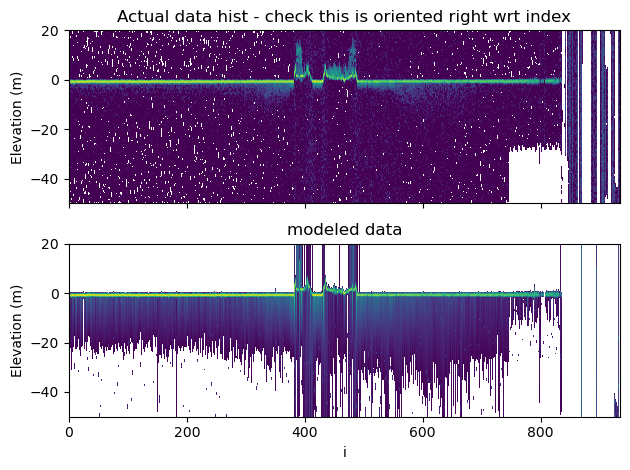

In [13]:
# create a model maker
M = oo.ModelMaker(res_along_track=250,
                  res_z=0.25,
                  range_z=(-50, 20),
                  window_size=1,
                  step_along_track=1)

# use the parameters of this model to process the profile from before
m = M.process(p)

# vizualize overally quality of model fit in terms of resolution/scale
m.show()

Recall that the model is basically made of a bunch of fitted histograms along track. We can inspect the quality of individual models to get a sense of how well the model is matching our expectations. (Note log axes!)

At the moment, individual waveforms are indexed by the along track bin at the center of the window. For step_along_track = 1, its just the standard integer index.

In [14]:
w = m.waves[2]

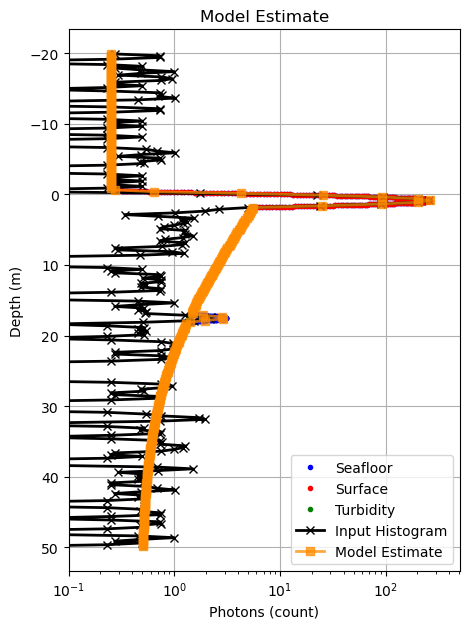

In [17]:
w.show(logplot=True);

In [32]:
w.profile.data.columns

Index(['land_surf', 'signal', 'classification', 'lon', 'lat', 'time', 'rgt',
       'cycle', 'region', 'track', 'segment_id', 'segment_dist', 'sc_orient',
       'atl03_cnf', 'height', 'quality_ph', 'delta_time', 'pair', 'geometry',
       'ref_azimuth', 'ref_elev', 'dist_ph_along', 'surf_type_land',
       'surf_type_ocean', 'surf_type_inland_water', 'geoid_z'],
      dtype='object')

,input,depth,output,noise,surface,bathy,turbidity,output_f,noise_f,surface_f,bathy_f,turbidity_f
0,0.272572,-19.875,0.250221,0.250221,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN
1,0.727428,-19.625,0.250221,0.250221,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN
2,0.726987,-19.375,0.250221,0.250221,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN
3,0.250221,-19.125,0.250221,0.250221,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN
4,0.022792,-18.875,0.250221,0.250221,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN


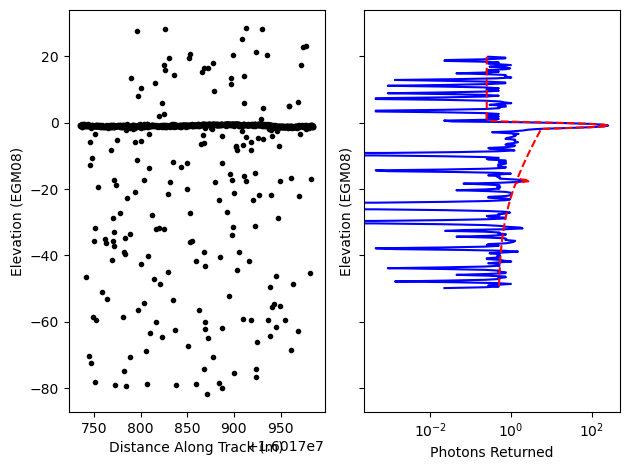

In [41]:
# can also inspect and manipulate individual waveform data at this level

# photon data
along_track_distance = w.profile.data.dist_ph_along
geoidal_height = w.profile.data.height - w.profile.data.geoid_z
input_histogram_data = w.model.input
output_modeled_data = w.model.output
elevations = -w.model.depth

f,ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(along_track_distance, geoidal_height, 'k.')
ax[0].set_ylabel('Elevation (EGM08)')
ax[0].set_xlabel('Distance Along Track (m)')

ax[1].plot(input_histogram_data, elevations, 'b')
ax[1].plot(output_modeled_data, elevations, 'r--')
ax[1].set_ylabel('Elevation (EGM08)')
ax[1].set_xlabel('Photons Returned')
ax[1].set_xscale('log')
f.tight_layout()
w.model.head()


Qualitatively comparing the original histogrammed photon data and the reconstructed scene...

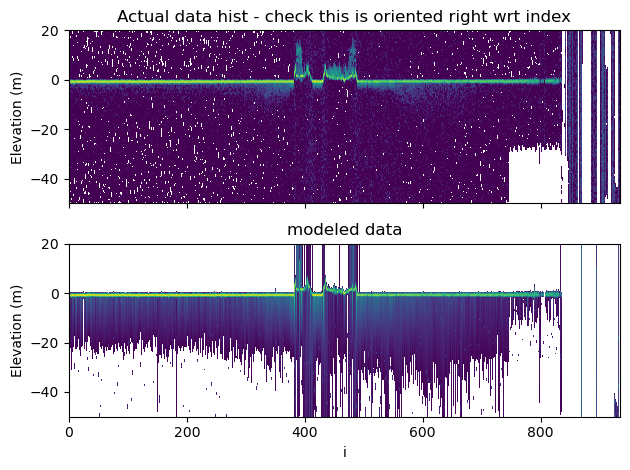

In [22]:
m.show()

Calculating a turbidity score as the discrete integral of the exponential decay component...

In [19]:
df = m.params
df.loc[:, 'turb_score'] = 0

for i in m.params.index:
    # integral of turbidity model
    df.loc[i, 'turb_score'] = np.sum(m.waves[i].model.turbidity)

Using prior to isolate known good bathy for plotting purposes, using a surface to bathy ratio of 3 and a height threshold. Given a sufficiently high resolution ocean mask, we can us the clip_to_ocean() module for this step in the future.

In [10]:
# p.clip_to_ocean() # clips the photon data under the hood

good_bathy = (m.params.bathy_conf>3) & (-m.params.surf_loc< 0.5)


Text(0.5, 0, 'Latitude (deg)')

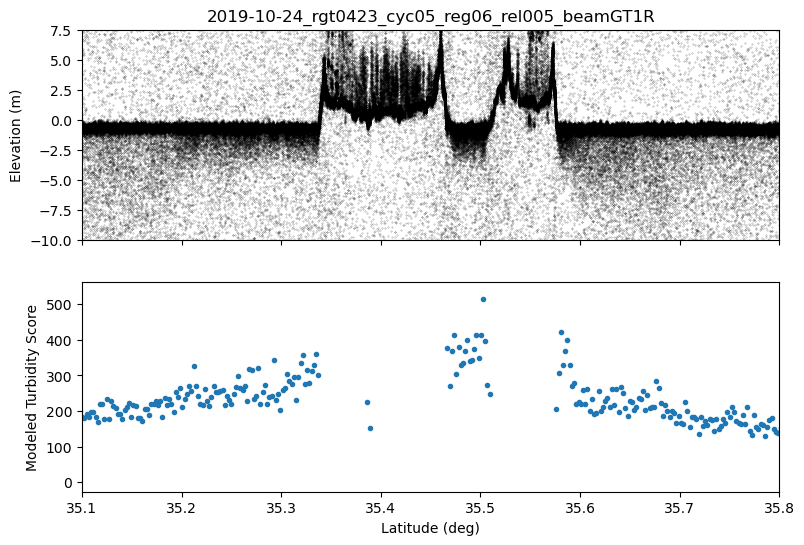

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=[9, 6])

ax1.plot(p.data.lat, p.data.height - p.data.geoid_z, 'k.', alpha=0.5, markersize=0.5, label='Photon Data')
# ax1.plot(m.params.y_med[good_bathy], -m.params.bathy_loc[good_bathy], 'r.', markersize=5, label='High Conf Bathy')
ax1.set_title(p.get_formatted_filename())
ax1.set_xlim([35.1, 35.8])
ax1.set_ylim([-10, 7.5])
ax1.set_ylabel('Elevation (m)')


all_surf = (-m.params.surf_loc < 0.2) & (m.params.quality_flag > 0)
ax2.plot(df.y_med[all_surf], df.turb_score[all_surf], '.')
# ax2.set_title('Turbidity ')
ax2.set_ylabel('Modeled Turbidity Score')
ax2.set_xlabel('Latitude (deg)')


In [28]:
m.params



,i,x_med,y_med,at_med,quality_flag,bathy_conf,sat_flag,sat_check,n_photons,surf_prom,...,surf_loc_f,surf_std_f,decay_param_f,trans_mult_f,noise_above_f,noise_below_f,bathy_prom_f,bathy_loc_f,bathy_std_f,turb_score
0,0,-75.283874,36.426909,1.601737e+07,3,1.155982,0,False,1266,312.160742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.612439e+02
1,1,-75.284266,36.424791,1.601761e+07,3,1.126986,0,False,1171,316.276158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.317323e+02
2,2,-75.284689,36.422526,1.601786e+07,3,1.139334,0,False,1092,260.336614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.862980e+02
3,3,-75.285108,36.420287,1.601811e+07,3,1.042972,0,False,1112,300.708487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.273441e+02
4,4,-75.285522,36.418078,1.601836e+07,3,1.154097,0,False,1155,262.267364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.263711e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,930,-75.633872,34.349911,1.624978e+07,2,-1.000000,0,False,314,2.472536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
931,931,-75.634291,34.346518,1.625016e+07,-3,-1.000000,0,False,4712,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
932,932,-75.634507,34.344723,1.625036e+07,3,2.138860,0,False,8176,6.310369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.302310e-19
933,933,-75.634783,34.342460,1.625061e+07,-3,-1.000000,0,False,8219,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [25]:
m.params.columns


Index(['i', 'x_med', 'y_med', 'at_med', 'quality_flag', 'bathy_conf',
       'sat_flag', 'sat_check', 'n_photons', 'surf_prom', 'surf_loc',
       'surf_std', 'decay_param', 'trans_mult', 'noise_above', 'noise_below',
       'bathy_prom', 'bathy_loc', 'bathy_std', 'surf_prom_f', 'surf_loc_f',
       'surf_std_f', 'decay_param_f', 'trans_mult_f', 'noise_above_f',
       'noise_below_f', 'bathy_prom_f', 'bathy_loc_f', 'bathy_std_f',
       'turb_score'],
      dtype='object')